# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [33]:
#%%pycodestyle


def _distance_func(a, b):
    a_2 = (a ** 2).sum(axis=1)
    b_2 = (b ** 2).sum(axis=1)
    ab = a.dot(b.T)
    temp = a_2.reshape(-1, 1) - 2*ab + b_2
    temp[temp < 0] = 0
    return np.sqrt(temp)


class MyKmeans:

    def _rand_init(self, X):
        self.centroids = X[np.random.choice(X.shape[0], size=self.k)]

    def _better_init(self, X):
        self.centroids[0] = X[np.random.choice(X.shape[0])]
        for i in range(1, self.k):
            dist_m = self.metric(X, self.centroids[:i, :]).min(axis=1)
            self.centroids[i] = X[np.random.choice(X.shape[0],
                                                   p=dist_m/dist_m.sum())]

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = _distance_func
        if init == 'random':
            self.centroids_init = self._rand_init
        elif init == 'k-means':
            self.centroids_init = self._better_init
        self.max_iter = max_iter
        self.epsilon = 0.1

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        self.centroids_init(X)

        for _ in range(self.max_iter):
            new_centroids = np.empty((self.k, X.shape[1]))
            self.labels = self.metric(X, self.centroids).argmin(axis=1)
            for i in range(self.k):
                if np.any(self.labels == i):
                    new_centroids[i] = np.mean(X[self.labels == i], axis=0)
                else:
                    new_centroids[i] = X[np.random.choice(X.shape[0])]
            if np.all(np.abs(new_centroids - self.centroids) < self.epsilon):
                break
            self.centroids = np.copy(new_centroids)
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        return self.metric(X, self.centroids).argmin(axis=1)


class MiniBatchKMeans(MyKmeans):

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', batch_size=100):

        super(MiniBatchKMeans, self).__init__(k=k, metric=_distance_func,
                                              max_iter=max_iter,
                                              random_state=random_state,
                                              init=init)
        self.batch_size = batch_size

    def fit(self, X, y=None):
        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))
        amount_matrix = np.zeros(self.k)

        self.centroids_init(X)

        for _ in range(self.max_iter):
            rand_m = X[np.random.choice(X.shape[0],
                                        size=self.batch_size,
                                        replace=False)]
            self.labels = self.metric(rand_m, self.centroids).argmin(axis=1)
            new_centroids = np.copy(self.centroids)
            for i in range(rand_m.shape[0]):
                cluster = self.labels[i]
                amount_matrix[cluster] += 1
                w = 1 / amount_matrix[cluster]
                new_centroids[cluster] = (1 - w) * new_centroids[cluster] +\
                    w * rand_m[i]
            if np.all(np.abs(new_centroids - self.centroids) <= self.epsilon):
                break
            self.centroids = np.copy(new_centroids)
        self.labels = self.metric(X, self.centroids).argmin(axis=1)

        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

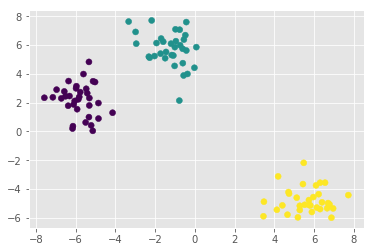

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [6]:
def check_method(method, X):
    labels = method.fit(X).labels

    for centroid in method.centroids:
        plt.scatter(centroid[0], centroid[1], s=337)
    plt.scatter(X[:, 0], X[:, 1], c=y)


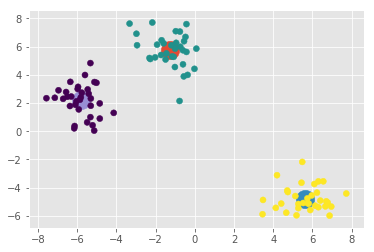

In [7]:
## Работоспособность MyKmeans
check_method(MyKmeans(k=3, random_state=42), X)

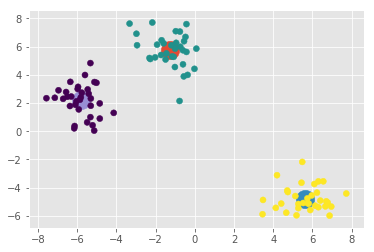

In [8]:
## Работоспособность MyKmeans++
check_method(MyKmeans(k=3, random_state=42), X)

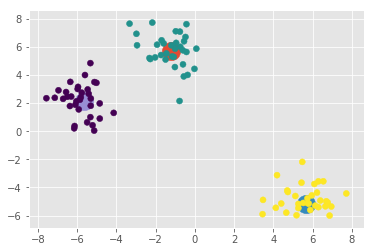

In [9]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
check_method(MiniBatchKMeans(k=3, random_state=42, batch_size=10), X)

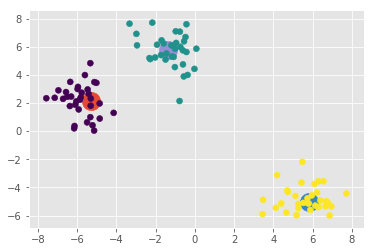

In [10]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
check_method(MiniBatchKMeans(k=3, random_state=42, init='k-means', batch_size=10), X)

In [11]:
from sklearn.cluster import KMeans
alg = KMeans(n_clusters=3, random_state=42)

In [12]:
%%time
## Время выполнения алгоритма Kmeans из sklearn
alg.fit(X)

Wall time: 14.9 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [13]:
alg = MyKmeans(k=3, random_state=42)

In [14]:
%%time
## Время выполнения алгоритма MyKmeans
alg.fit(X)

Wall time: 1.01 ms


In [15]:
alg = MyKmeans(k=3, random_state=42, init='k-means')

In [16]:
%%time
## Время выполнения алгоритма MyKmeans++
alg.fit(X)

Wall time: 1.48 ms


In [17]:
alg = MiniBatchKMeans(k=3, random_state=42)

In [18]:
%%time
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
alg.fit(X)

Wall time: 2.48 ms


In [19]:
alg = MiniBatchKMeans(k=3, random_state=42, init='k-means')

In [20]:
%%time
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
alg.fit(X)

Wall time: 11.9 ms


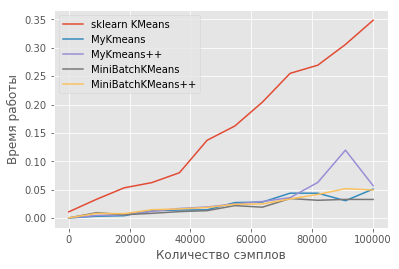

In [31]:
from timeit import default_timer

sizes = np.linspace(10, 100000, 12, dtype=int)
methods = [(KMeans(n_clusters=3, max_iter=100), 'sklearn KMeans'),
          (MyKmeans(k=3, max_iter=100, 
                    random_state=42), 'MyKmeans'),
          (MyKmeans(k=3, max_iter=100, random_state=42,
                    init='k-means'), 'MyKmeans++'),
          (MiniBatchKMeans(k=3, max_iter=100, random_state=42, 
                           batch_size=10), 'MiniBatchKMeans'),
          (MiniBatchKMeans(k=3, max_iter=100, random_state=42,
                           init='k-means', batch_size=10), 
                           'MiniBatchKMeans++')]
time = np.empty((len(methods), sizes.shape[0]))

for a, k in enumerate(sizes):
    X, y = make_blobs(n_samples=k, n_features=2, centers=3,
                      cluster_std=1, shuffle=True, random_state=42)

    for b, method in enumerate(methods):
        time0 = default_timer()
        method[0].fit(X)
        time[b][a] = default_timer() - time0

for i, method in enumerate(methods):
    plt.plot(sizes, time[i], label=method[1])

plt.xlabel('Количество сэмплов')
plt.ylabel('Время работы')
plt.legend()
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [22]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [23]:
df = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis=1)
X = df.values
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [24]:
def n_top(method, X, n=10, cluster_amount=9):
    method.fit(X)
    for i in range(cluster_amount):
        print("Кластер {} с количеством элементов {}:".format(i+1, X[method.labels == i].shape[0]))
        print(df.columns[X[method.labels == i].sum(axis=0).argsort()[-n:][::-1]].values)
        

In [25]:
## MyKMeans
n_top(MyKmeans(k=9, random_state=42), X)

Кластер 1 с количеством элементов 19370:
['blonde' 'tennis' 'death' 'soccer' 'jesus' 'bible' 'drunk' 'die' 'sex'
 'marching']
Кластер 2 с количеством элементов 896:
['kissed' 'drugs' 'hair' 'sex' 'drunk' 'die' 'clothes' 'rock' 'music'
 'death']
Кластер 3 с количеством элементов 914:
['dance' 'dress' 'music' 'cute' 'shopping' 'hair' 'mall' 'church' 'rock'
 'hot']
Кластер 4 с количеством элементов 554:
['sexy' 'cute' 'hot' 'sex' 'hair' 'rock' 'drunk' 'clothes' 'dance'
 'basketball']
Кластер 5 с количеством элементов 4172:
['shopping' 'cute' 'mall' 'dress' 'clothes' 'swimming' 'hot'
 'cheerleading' 'hair' 'music']
Кластер 6 с количеством элементов 548:
['bible' 'jesus' 'god' 'church' 'death' 'die' 'music' 'rock' 'swimming'
 'band']
Кластер 7 с количеством элементов 2129:
['basketball' 'baseball' 'softball' 'volleyball' 'football' 'sports'
 'soccer' 'rock' 'church' 'tennis']
Кластер 8 с количеством элементов 574:
['marching' 'band' 'music' 'rock' 'football' 'god' 'tennis' 'dress'
 'swimmin

1. Кластер слишком большой, делать выводы сложно и бессмыссленно
2. Люди с интересным досугом
3. Предположительно девушки
4. Предположительно молодые люди в совокупности
5. Предположительно девушки
6. Чуть более религиозные люди
7. Любители спорта
8. Люди, предпочитающие активный отдых
9. Люди, активно пользующиеся Интернет-покупками

In [26]:
## MyKMeans++
n_top(MyKmeans(k=9, random_state=42, init='k-means'), X)

Кластер 1 с количеством элементов 20881:
['marching' 'blonde' 'band' 'jesus' 'bible' 'tennis' 'death' 'swimming'
 'god' 'die']
Кластер 2 с количеством элементов 148:
['kissed' 'sex' 'hair' 'rock' 'music' 'drugs' 'sports' 'clothes' 'die'
 'drunk']
Кластер 3 с количеством элементов 1234:
['drugs' 'kissed' 'drunk' 'hair' 'die' 'sex' 'clothes' 'death' 'music'
 'band']
Кластер 4 с количеством элементов 773:
['cheerleading' 'bible' 'jesus' 'god' 'church' 'shopping' 'football' 'hot'
 'hollister' 'abercrombie']
Кластер 5 с количеством элементов 392:
['volleyball' 'softball' 'basketball' 'shopping' 'sports' 'football'
 'swimming' 'cute' 'hot' 'church']
Кластер 6 с количеством элементов 1:
['blonde' 'sex' 'drunk' 'death' 'hair' 'die' 'god' 'dress' 'football'
 'clothes']
Кластер 7 с количеством элементов 2776:
['football' 'basketball' 'baseball' 'sports' 'soccer' 'softball' 'tennis'
 'church' 'rock' 'volleyball']
Кластер 8 с количеством элементов 3237:
['shopping' 'hollister' 'abercrombie' 'mall'

1. Кластер слишком большой, делать выводы сложно и бессмыссленно
2. Люди с интересным досугом
3. (Если воспринимать 'drugs' как 'лекарства')Болезные любители поцелуев и опьянения
4. Религиозные люди
5. Любители спорта
6. Кластер слишком мал, чтобы его отдельно анализировать
7. Любители спорта
8. Интернет-покупатели
9. Допустим, девушки

In [27]:
## MyKMeans с MiniBatchMyKMeans
n_top(MiniBatchKMeans(k=9, random_state=42), X)

Кластер 1 с количеством элементов 2541:
['swimming' 'soccer' 'volleyball' 'tennis' 'shopping' 'music' 'sports'
 'blonde' 'rock' 'basketball']
Кластер 2 с количеством элементов 684:
['drugs' 'kissed' 'hair' 'sex' 'drunk' 'music' 'die' 'clothes' 'rock'
 'sports']
Кластер 3 с количеством элементов 1553:
['dance' 'hot' 'mall' 'cute' 'hair' 'clothes' 'rock' 'shopping' 'music'
 'church']
Кластер 4 с количеством элементов 824:
['dress' 'sexy' 'cute' 'shopping' 'hair' 'dance' 'clothes' 'hot' 'mall'
 'sex']
Кластер 5 с количеством элементов 2272:
['shopping' 'marching' 'cheerleading' 'band' 'clothes' 'cute' 'mall'
 'tennis' 'music' 'church']
Кластер 6 с количеством элементов 1600:
['die' 'basketball' 'sports' 'death' 'softball' 'volleyball' 'rock' 'god'
 'music' 'hair']
Кластер 7 с количеством элементов 17237:
['blonde' 'tennis' 'drunk' 'bible' 'sex' 'jesus' 'softball' 'marching'
 'sexy' 'death']
Кластер 8 с количеством элементов 2442:
['football' 'church' 'baseball' 'bible' 'jesus' 'god' 'bask

1. Любители спорта
2. Люди с интересным досугом
3. Девушки
4. Девушки
5. Девушки, предпочитающие активный отдых
6. Любители спорта, слушающие дэт-металл
7. Большой кластер, не анализируется в элементарных функциях
8. Любители спорта, религиозные
9. Интернет-покупатели

In [28]:
## MyKMeans++ с MiniBatchMyKMeans
n_top(MiniBatchKMeans(k=9, random_state=42, init='k-means'), X)

Кластер 1 с количеством элементов 22842:
['bible' 'blonde' 'tennis' 'jesus' 'marching' 'swimming' 'death' 'god'
 'band' 'softball']
Кластер 2 с количеством элементов 13:
['sex' 'kissed' 'hair' 'sports' 'drugs' 'music' 'abercrombie' 'clothes'
 'death' 'die']
Кластер 3 с количеством элементов 609:
['drugs' 'marching' 'band' 'hair' 'kissed' 'sex' 'music' 'drunk' 'die'
 'rock']
Кластер 4 с количеством элементов 475:
['cheerleading' 'shopping' 'abercrombie' 'hollister' 'football' 'cute'
 'hot' 'mall' 'dance' 'church']
Кластер 5 с количеством элементов 379:
['volleyball' 'softball' 'basketball' 'shopping' 'sports' 'football'
 'swimming' 'church' 'hot' 'cute']
Кластер 6 с количеством элементов 1:
['blonde' 'sex' 'drunk' 'death' 'hair' 'die' 'god' 'dress' 'football'
 'clothes']
Кластер 7 с количеством элементов 2604:
['football' 'baseball' 'sports' 'basketball' 'soccer' 'softball' 'church'
 'rock' 'tennis' 'jesus']
Кластер 8 с количеством элементов 2952:
['clothes' 'hair' 'shopping' 'dance' 'c

1. Большой кластер, не берётся анализом глазами
2. Малый кластер, зачем обращать на него внимание
3. Болезные люди, предпочитащие активный отдых
4. Девушки
5. Любители спорта
6. Ещё один малый кластер
7. Любители спорта
8. Девушки
9. Что-то невнятное

## Вывод

Не могу выявить однозначно лучшего метода. Все работают примерно одинаковое время на предложенных данных, и причём практически одинаково хорошо. В ++-версиях из-за улучшенной инициализции центроидов получились кластеры, менее похожие друг на друга, чем в обычных версиях (то есть, наверняка, это говорит о том, что ++-версии методов объективно лучше)